## Text Classification - Reddit

### Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.linear_model import  LogisticRegression
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from yellowbrick.text import FreqDistVisualizer
from nltk.corpus import stopwords
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re

### Read data previously saved from Data Acquisition notebook

In [4]:
df_eat = pd.read_pickle('./data/eatcheap.pkl')

In [ ]:
df_eat.shape

In [5]:
df_science = pd.read_pickle('./data/science.pkl')

In [6]:
df_science.shape

(1001, 6)

### Data Cleaning

In [7]:
df = pd.concat([df_eat, df_science])
df = df.reset_index(drop=True)
df.subreddit.value_counts()

askscience            1001
EatCheapAndHealthy     744
Name: subreddit, dtype: int64

In [8]:
df.head()

,is_self,name,subreddit,text,title,url
0,True,t3_anw68l,EatCheapAndHealthy,EDIT : We have added some Popular posts to the...,[MOD PSA] PLEASE use our search bar to find qu...,https://www.reddit.com/r/EatCheapAndHealthy/co...
1,True,t3_b84w1m,EatCheapAndHealthy,I can't stress this enough. I changed my entir...,Double roast your spaghetti squash.,https://www.reddit.com/r/EatCheapAndHealthy/co...
2,True,t3_b84y4p,EatCheapAndHealthy,One of the things that frustrates me about coo...,"Making your own ""pre-packaged"" ingredients",https://www.reddit.com/r/EatCheapAndHealthy/co...
3,True,t3_b7x5o2,EatCheapAndHealthy,A thread at the start of the weekend discussed...,Making lemons into not-lemonade,https://www.reddit.com/r/EatCheapAndHealthy/co...
4,True,t3_b8376g,EatCheapAndHealthy,"Hi all, \nI *crave* instant noodles but I know...",Healthy and easy instant noodles ?,https://www.reddit.com/r/EatCheapAndHealthy/co...


In [9]:
df.drop_duplicates(inplace=True)

In [10]:
# calculate baseline
df.subreddit.value_counts(normalize=True)

askscience            0.573639
EatCheapAndHealthy    0.426361
Name: subreddit, dtype: float64

In [11]:
# combine title and selftext into one text column
df['text'] = df['text'] +' '+ df['title']

In [12]:
# Binarize label column
df['science'] = df['subreddit'].apply(lambda x: 1 if x == 'askscience' else 0)

# get rid of \n in text
df['text'] = df['text'].map(lambda x: x.replace('\n',' '))

df['text'] = df['text'].map(lambda x: x.replace('&amp;','and'))

In [13]:
# Load stopwords from NLTK and add custom words
mystopwords = stopwords.words('english')

mystopwords.extend(['like','would','get','x200b','https','one','www','com','org','etc','could'])

### Modeling: Logistic Regression

In [34]:
X = df['text']  # X will be turned into a matrix
y = df['science']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify =y)

In [15]:
# Logistic Regression model with Count Vectorizer
cvec = CountVectorizer(stop_words=mystopwords,max_features=5000)

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

lr = LogisticRegression(solver='lbfgs',C=3)

lr.fit(X_train_cvec, y_train)

print('Logistic Regression model with Count Vectorizer')
# Training score
print(f'Train score: {lr.score(X_train_cvec, y_train):.3f}')

# Test score
print(f'Test score: {lr.score(X_test_cvec, y_test):.3f}')

Logistic Regression model with Count Vectorizer
Train score: 1.000
Test score: 0.968


In [35]:
# Logistic Regression model with TF-IDF Vectorizer
tvec = TfidfVectorizer(stop_words=mystopwords,max_features=5000)

X_train_tvec = tvec.fit_transform(X_train)
X_test_tvec = tvec.transform(X_test)

lr = LogisticRegression(solver='lbfgs',C=4)

lr.fit(X_train_tvec, y_train)

print('Logistic Regression model with TF-IDF Vectorizer')
# Training score
print(f'Train score: {lr.score(X_train_tvec, y_train):.3f}')

# Test score
print(f'Test score: {lr.score(X_test_tvec, y_test):.3f}')

Logistic Regression model with TF-IDF Vectorizer
Train score: 1.000
Test score: 0.982


### Modeling: Naive Bayes and SVM Models

In [22]:
# set up X, y for Naive Bayes and SVM Models
X = df[['text']]  # X is a pd Dataframe
y = df['science']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42, stratify =y)

In [23]:
cvec = CountVectorizer(stop_words=mystopwords,max_features=5000, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())

# instantiate and fit model 
nb = BernoulliNB(alpha=0.03)
nb.fit(X_train_cvec, y_train)

# Score model on the training set.
print('Naive Bayes Bernoulli model with Count Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_cvec,y_test):.3f}')

Naive Bayes Bernoulli model with Count Vectorizer
Train data accuracy: 0.976
Test data accuracy: 0.973


In [120]:
tvec = TfidfVectorizer(stop_words=mystopwords,max_features=3000, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train['text']).todense(),
                            columns = tvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_tvec = pd.DataFrame(tvec.transform(X_test['text']).todense(),
                           columns = tvec.get_feature_names())

# instantiate and fit model 
nb = BernoulliNB(alpha=.03)
nb.fit(X_train_tvec, y_train)

# Score model on the training set.
print('Naive Bayes Bernoulli model with TF-IDF Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_tvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_tvec,y_test):.3f}')

Naive Bayes Bernoulli model with TF-IDF Vectorizer
Train data accuracy: 0.971
Test data accuracy: 0.973


In [24]:
cvec = CountVectorizer(stop_words=None,max_features=500,min_df=1, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())

# instantiate and fit model 
nb = MultinomialNB(alpha=1)
nb.fit(X_train_cvec, y_train)

# Score model on the training set.
print('Naive Bayes Multinomial model with Count Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_cvec,y_test):.3f}')

Naive Bayes Multinomial model with Count Vectorizer
Train data accuracy: 0.984
Test data accuracy: 0.989


In [139]:
tvec = TfidfVectorizer(stop_words=None,max_features=2000,min_df=2, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_tvec = pd.DataFrame(tvec.fit_transform(X_train['text']).todense(),
                            columns = tvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_tvec = pd.DataFrame(tvec.transform(X_test['text']).todense(),
                           columns = tvec.get_feature_names())

# instantiate and fit model 
nb = MultinomialNB(alpha=.3)
nb.fit(X_train_tvec, y_train)

# Score model on the training set.
print('Naive Bayes Multinomial model with TF-IDF Vectorizer')
print(f'Train data accuracy: {nb.score(X_train_tvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {nb.score(X_test_tvec,y_test):.3f}')

Naive Bayes Multinomial model with TF-IDF Vectorizer
Train data accuracy: 0.997
Test data accuracy: 0.991


### Analyze Results of Best Model

In [26]:
# print confusion matrix
y_pred = nb.predict(X_test_cvec)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=['predict neg', 'predict pos'], index=['actual neg', 'actual pos'])
cm_df

,predict neg,predict pos
actual neg,184,2
actual pos,3,248


In [28]:
# add predicted and actual y to test dataset
X_test['y_test'] = pd.Series(y_test, index=X_test.index)
X_test['y_pred'] = pd.Series(y_pred, index=X_test.index)

# count words in text
X_test['word_count'] = pd.Series([len(re.findall(r'\w+', x)) for x in X_test.text], 
                                 index=X_test.index)

C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\pauls\Anaconda3\envs\dsi\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

In [29]:
X_test['word_count'].mean()

83.09610983981693

In [30]:
# list false positives - predicted Science but actually EatCheap
mask = (X_test['y_test']==0) & (X_test['y_pred'] ==1)
X_test[mask]

,text,y_test,y_pred,word_count
385,"Join the frugality chat room, we like to hunt ...",0,1,46
308,What is the least worst alcohol for losing we...,0,1,9


In [31]:
X_test.text.loc[385]

'Join the frugality chat room, we like to hunt for good deals and talk about all things having to do with being frugal and saving money. Just overall being efficient with resources.  Join by clicking here [https://discord.gg/VTdx8FY](https://discord.gg/VTdx8FY) Frugal discord'

In [32]:
# list false negatives -- predicted Cooking but actually science
mask = (X_test['y_test']==1) & (X_test['y_pred'] ==0)
X_test[mask]

,text,y_test,y_pred,word_count
804,I originally posted this in r/explainlikeimfiv...,1,0,58
1382,What is happening in our lips/mouth that caus...,1,0,18
1093,"Or as my dad says, ""clears your sinuses"" What ...",1,0,17


In [147]:
X_test.text.loc[804]

"I originally posted this in r/explainlikeimfive and it was removed because it has to do with genetics and things. So why is it that some people are allergic to eating eggs but not chicken itself, and others can eat chicken but not eggs? Why are some people allergic to eating chicken's eggs, not not chicken itself?"

In [33]:
X_test.text.loc[1382]

' What is happening in our lips/mouth that causes spicy foods we eat to feel hot or "spicy"?'

In [149]:
X_test.text.loc[1065]

"I'm guessing it could change with frying etc. With oil from outside the food but what happens in the inside ?  Do both purée potato and potato in a stew have same calories given they are equal in weight.  Or does it differ with meats, veggies or eggs etc. depending on what kind of food is it ?  Please do enlighten me if its not a dumb question ! ^^ Does calorie in foods change depending on how its cooked ?"

In [36]:
from sklearn.metrics import classification_report
target_names = ['EatCheapAndHealthy','AskScience']
print(classification_report(y_test, y_pred, target_names=target_names))

                    precision    recall  f1-score   support

EatCheapAndHealthy       0.98      0.99      0.99       186
        AskScience       0.99      0.99      0.99       251

         micro avg       0.99      0.99      0.99       437
         macro avg       0.99      0.99      0.99       437
      weighted avg       0.99      0.99      0.99       437



In [110]:
# SVM model
cvec = CountVectorizer(stop_words=mystopwords,max_features=250, ngram_range=(1,1))

# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(X_train['text']).todense(),
                            columns = cvec.get_feature_names())
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(X_test['text']).todense(),
                           columns = cvec.get_feature_names())
# Instantiate SVM.
svc = svm.SVC(kernel='rbf', C = 40, gamma = .01)

# Fit on training data.
svc.fit(X_train_cvec,y_train)

# Score model on the training set.
print('Support Vector Machine model with Count Vectorizer')
print(f'Train data accuracy: {svc.score(X_train_cvec,y_train):.3f}')

# Score our model on the testing set.
print(f'Test data accuracy: {svc.score(X_test_cvec,y_test):.3f}')

Support Vector Machine model with Count Vectorizer
Train data accuracy: 0.992
Test data accuracy: 0.961


### Data Visualization and EDA

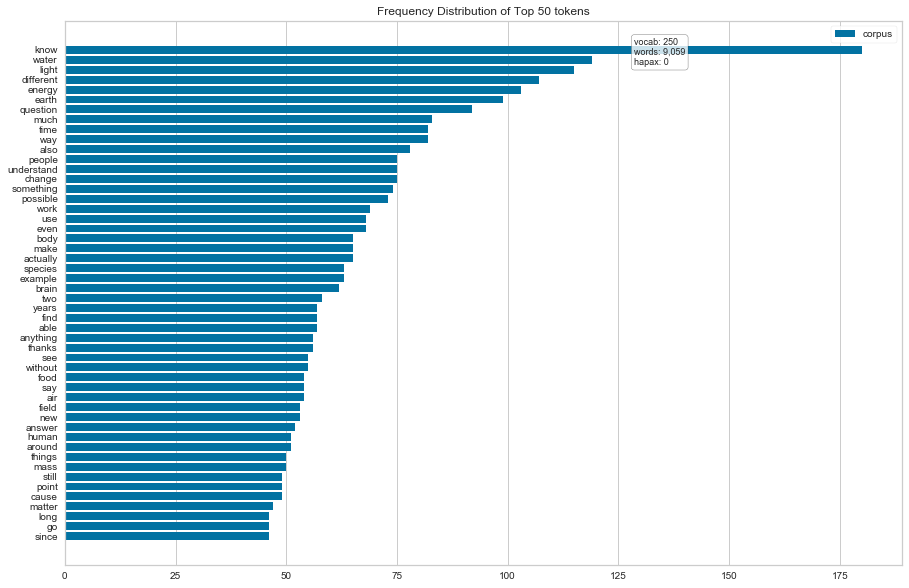

In [30]:
mask       = (df['science'] == 1)
docs       = cvec.fit_transform(text for text in df['text'][mask])
features   = cvec.get_feature_names()
plt.figure(figsize=(15,10))
visualizer = FreqDistVisualizer(features=features,n=50)
visualizer.fit(docs)
visualizer.poof()

In [34]:
# create df of words by frequency
word_freq = pd.DataFrame({'word':features,'freq':list(visualizer.count(docs))})
word_freq.sort_values(by = ['freq'],ascending=False)

,word,freq
115,know,180
237,water,119
122,light,115
51,different,107
64,energy,103
55,earth,99
167,question,92
141,much,83
220,time,82
240,way,82


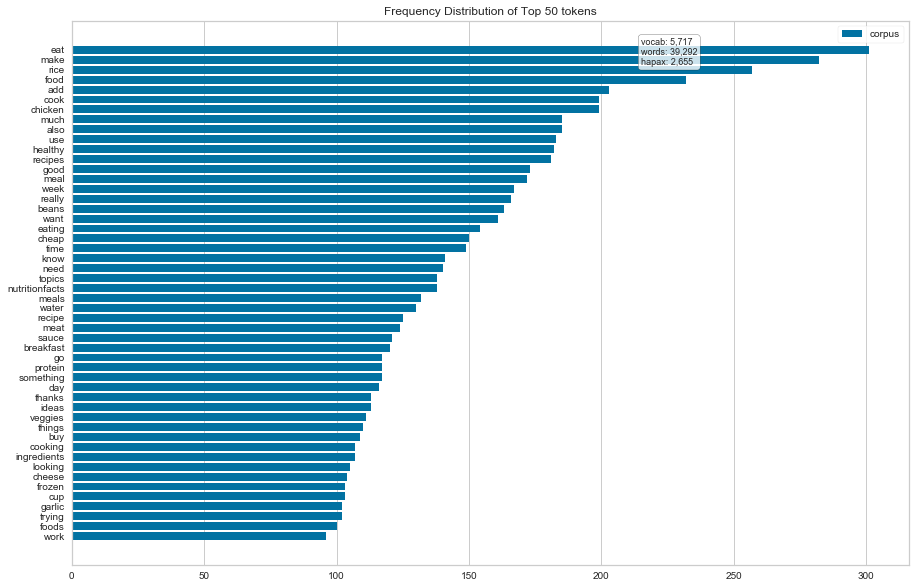

In [272]:
mask       = (df['science'] == 0)
docs       = cvec.fit_transform(text for text in df['text'][mask])
features   = cvec.get_feature_names()
plt.figure(figsize=(15,10))
visualizer = FreqDistVisualizer(features=features,n=50,color=('r','green'))
visualizer.fit(docs)
visualizer.poof()

In [31]:
# create function to display wordclouds
def make_wc(mask):
    # use visualizer to create word frequency list for Wordcloud
    # (it is also possible to let wordcloud create the list)
    docs       = cvec.fit_transform(text for text in df['text'][mask])
    features   = cvec.get_feature_names()
    #create dataframe of word frequencies
    word_freq = pd.DataFrame({'word':features,'freq':list(visualizer.count(docs))})
    word_freq = word_freq.sort_values(by = ['freq'],ascending=False)
    # convert df into dict
    w_dict = dict([(word_freq['word'].iloc[i],word_freq['freq'].iloc[i]) for i in range(len(word_freq))])
    # Create and generate a word cloud image:
    wordcloud = WordCloud(width=1000,height=500,scale=1,background_color="white").generate_from_frequencies(w_dict)
    # Display the generated image:
    plt.rcParams['figure.figsize'] = (20, 10)
    fig = plt.figure()
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.tight_layout(pad=0)
    plt.axis("off")
    plt.show()
    return fig

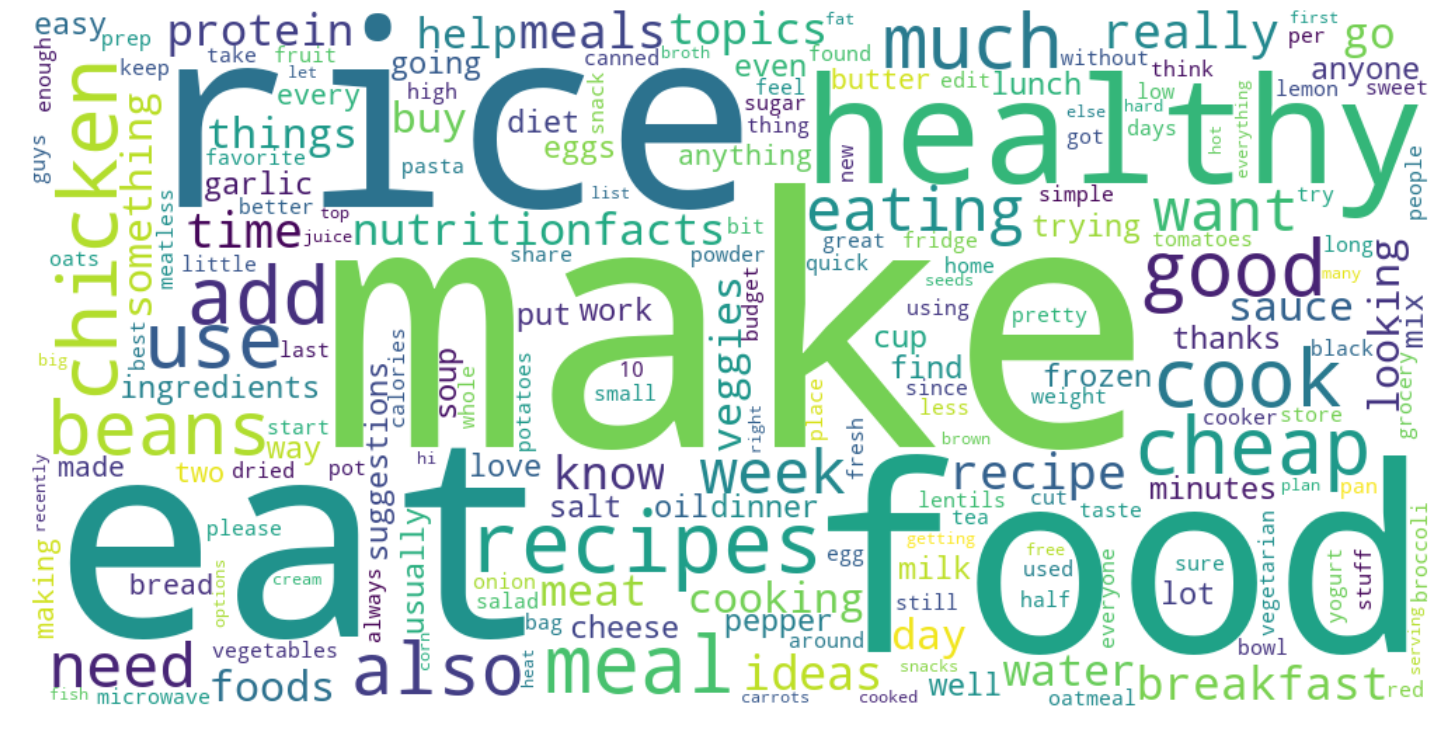

In [37]:
# display EatCheapAndHealthy wordcloud
mask = (df['science'] == 0)  # select which subreddit to use
name = 'eatcheap'  # name to use for image output file
fig = make_wc(mask)
fig.savefig(name+'.png', bbox_inches='tight');

### Gridsearch for best parameters (manual search used for final model selection)

In [15]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [36]:
# Fit your model
pipe.fit(X_train, y_train)

# Training score
print(f'Train score: {pipe.score(X_train, y_train)}')
 
# Test score
print(f'Test score: {pipe.score(X_test, y_test)}')

Train score: 0.9717125382262997
Test score: 0.9450800915331807


In [40]:
# Tune GridSearchCV
pipe_params = {
    'cvec__stop_words':['english'],  # prefix is name given when you set up pipeline + __
    'cvec__max_features' :[None],
    'cvec__ngram_range' : [(1,1),(1,2)]
}
gs = GridSearchCV(pipe, param_grid=pipe_params, cv=3, return_train_score=True) # cross validation happening with grid search
gs.fit(X_train, y_train);

In [41]:
gs.best_score_

0.9204892966360856

In [42]:
gs.best_params_

{'cvec__max_features': None,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english'}

In [43]:
# show grid search results by trial number
pd.DataFrame(gs.cv_results_).T

,0,1
mean_fit_time,0.0999941,0.213334
std_fit_time,0.0115678,0.0223659
mean_score_time,0.0326683,0.0479997
std_score_time,0.00449616,0.00245048
param_cvec__max_features,None,None
param_cvec__ngram_range,"(1, 1)","(1, 2)"
param_cvec__stop_words,english,english
params,"{'cvec__max_features': None, 'cvec__ngram_rang...","{'cvec__max_features': None, 'cvec__ngram_rang..."
split0_test_score,0.915138,0.915138
split1_test_score,0.928899,0.928899


In [44]:
pipe2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [48]:
# Tune GridSearchCV
pipe_params = {
    'tvec__stop_words':['english'],  # prefix is name given when you set up pipeline + __
    'tvec__max_features' :[500,1000,None],
    'tvec__min_df' :[1],
    'tvec__max_df' :[1.0], 
    'tvec__ngram_range' : [(1,1),(1,2)]
}
gs = GridSearchCV(pipe2, param_grid=pipe_params, cv=3,return_train_score=True) # cross validation happening with grid search
gs.fit(X_train, y_train);

In [49]:
# show grid search results by trial number
pd.DataFrame(gs.cv_results_).T

,0,1,2,3,4,5
mean_fit_time,0.0790046,0.17701,0.128666,0.179662,0.083321,0.203003
std_fit_time,0.0185353,0.0182371,0.0145206,0.0128246,0.00882076,0.0325726
mean_score_time,0.0256734,0.040323,0.050333,0.0393302,0.0346683,0.0589969
std_score_time,0.00124015,0.00826168,0.00188329,0.00047447,0.000472438,0.00509804
param_tvec__max_df,1,1,1,1,1,1
param_tvec__max_features,500,500,1000,1000,None,None
param_tvec__min_df,1,1,1,1,1,1
param_tvec__ngram_range,"(1, 1)","(1, 2)","(1, 1)","(1, 2)","(1, 1)","(1, 2)"
param_tvec__stop_words,english,english,english,english,english,english
params,"{'tvec__max_df': 1.0, 'tvec__max_features': 50...","{'tvec__max_df': 1.0, 'tvec__max_features': 50...","{'tvec__max_df': 1.0, 'tvec__max_features': 10...","{'tvec__max_df': 1.0, 'tvec__max_features': 10...","{'tvec__max_df': 1.0, 'tvec__max_features': No...","{'tvec__max_df': 1.0, 'tvec__max_features': No..."
